# Basic Cross-Validation Experiment on the ExtraSensory data set with Backend Comparison

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Attempt to disable multi-threading in NumPy 
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
try:
    import mkl
    mkl.set_num_threads(1)
except:
    print("MKL not available")

MKL not available


In [2]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install ./mFlow
else:
    print("mFlow module found")

mFlow module found


## Import modules

In [3]:
from mFlow.Blocks.data_loader_extrasensory import extrasensory_data_loader
from mFlow.Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from mFlow.Blocks.imputer import Imputer
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport
from mFlow.Workflow.workflow import workflow

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression

import time
import pandas as pd

## Define the workflow

This workflow performs four train/test experiments on the ExtraSensory data set sleeping prediction task to illustrate the use of different scheduler back ends. The data are loaded once, followed by four parallel copies of the remaining workflow, which includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation and feature normalization. 

The demonstration compares the run time of three different workflow scheduler backends:  sequential, multithreaded, and multiprocess. We run the parallel schedulers with 1, 2 and 4 workers. We note that due to communication overhead between the master and worker threads in the multi-process backend, and issues with Python's global interpreter lock in the multi-threaded backend, parallel speedups can be less than linear even for seemingly embarassingly parallel tasks. Parallel speedups also depend on the number of avilable cores. Also note that this demo requires an extended run time. 

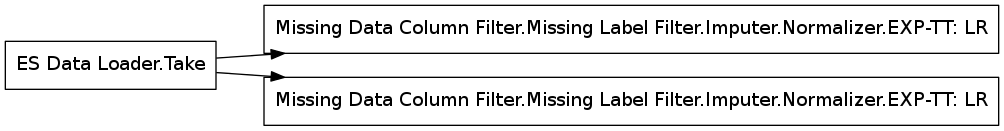

In [ ]:
estimators = {"LR": LogisticRegression(solver="lbfgs",C=1,max_iter=100,verbose=10)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]
configs    = {
             "sequential":[1],
             #"multithread":[2],
             #"multiprocess":[2],
             #"pipeline":[1],
             "multiprocess_pipeline":[2]
           }

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
df_sub    = Take(df_raw, 50000)
for i in range(2):
    df_cf     = MisingDataColumnFilter(df_sub);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

results={}
for config in configs:
    for workers in configs[config]:
        
        flow=workflow({"Results0":res[0],"Results1":res[1]} );        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=True, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"));